# ЛІНГВІСТИЧНЕ МОДЕЛЮВАННЯ

Імпортуємо необхідні бібліотеки

In [1]:
%matplotlib inline

import re

from collections import defaultdict
from functools import partial

import numpy as np
import pandas as pd
import seaborn as sns

Зчитуємо числовий ряд із файлу згідно варіанту

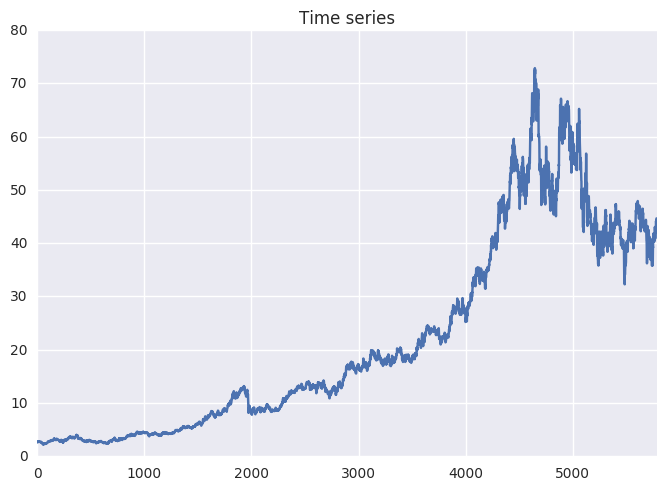

In [2]:
df = pd.read_csv('Dupont.csv', sep=';', header=None)  # Read dataframe
x = df[4]  # Get the column we need (indexing is zero based)
x.plot(title='Time series');

Обчислюємо різницевий ряд

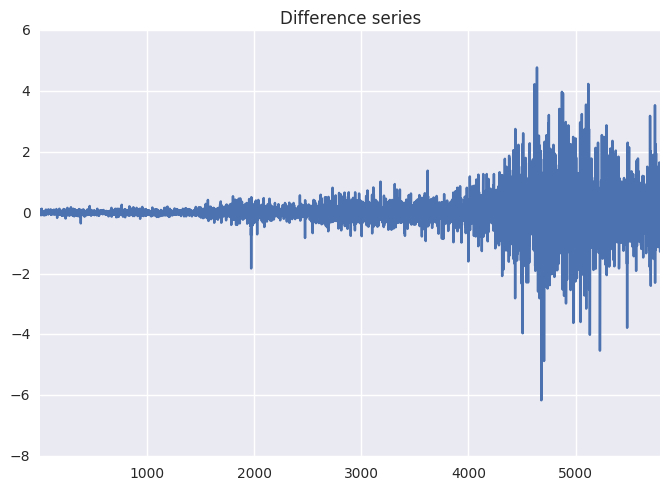

In [3]:
x_diff = x.diff(periods=1).dropna()
x_diff.plot(title='Difference series');

Сортуємо ряд за зросанням

In [4]:
x_diff_s = x_diff.sort_values()

Задамо алфавіт із символів англійського алфавіту:

$$ Alphabet = \{z, y, x, w, v, u, t, s, r, q, p, o, n, m, l, k, j, i, h, g, f, e, d, c, b, a, A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z\} $$

In [5]:
alphabet = [
    'z', 'y', 'x', 'w', 'v', 'u', 't', 's', 'r', 'q', 'p', 'o', 'n',
    'm', 'l', 'k', 'j', 'i', 'h', 'g', 'f', 'e', 'd', 'c', 'b', 'a', 
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
    'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'
]


N = len(alphabet)

Розділимо отримані відрізки $lesser$ та $greater$ числового ряду на відрізки однакової довжини

In [6]:
def approx_ranges(seq, n):
    rng = seq.max() - seq.min()
    slice_rng = rng / n
    
    min_ = seq.min()
    
    approx_ranges = [(min_ + slice_rng * i, min_ + slice_rng * (i + 1))
                     for i in range(n)]
    return approx_ranges
    
    
def split_range(seq, n):
    bounds = approx_ranges(seq, n)
    
    slices = []
    for (min_, max_) in bounds:
        slice_ = (
            seq.where(seq >= min_)
            .where(seq <= max_))
        if slices:
            slice_ = slice_.where(~slice_.isin(slices[-1]))
        slice_ = slice_.dropna().reset_index(drop=True)
        slices.append(slice_)
    return slices

In [7]:
range_bounds = approx_ranges(x_diff_s, N)

Будуємо відображення

$$
L(x_{i}) =
  \begin{cases}
    a_{j} & \quad \text{if } x_{i} \in I_{j-1,j}\\
    a_{N+j} & \quad \text{if } x_{i} \in J_{j-1,j}\\
  \end{cases}
$$

In [8]:
def num_to_char(num, bounds, alphabet):
    for (idx, (min_, max_)) in zip(range(len(bounds)), bounds):
        if min_ <= num <= max_:
            return alphabet[idx]

Застосовуємо відображення:

$$Y = map(l, X^1)$$

In [9]:
y = x_diff.apply(lambda x: num_to_char(x, range_bounds, alphabet))

Подальші операції стосуватимуться пошуку послідовностей символів у лінгвістичному ланцюжку, тому доцільно буде перевести послідовність у рядок

In [10]:
linguistic_seq = ''.join(y.tolist())

In [11]:
def occurrences(text, sub):
    return len(re.findall('(?={0})'.format(re.escape(sub)), text))


def matrix_of_occurences(lang, alphabet):
    usages = defaultdict(dict)

    for lead in alphabet:
        for follow in alphabet:
            text = lead + follow
            usages[lead][follow] = occurrences(lang, text)
            
    mtx = pd.DataFrame(usages)
    mtx = mtx[alphabet]
    mtx = mtx.reindex(alphabet)
    
    return mtx

In [12]:
mtx = matrix_of_occurences(linguistic_seq, alphabet)

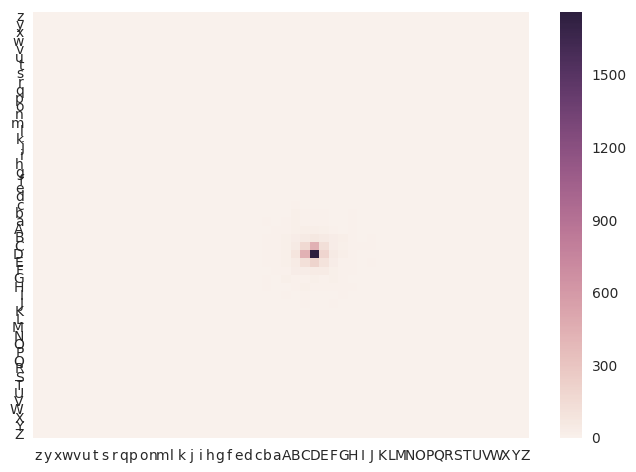

In [13]:
sns.heatmap(mtx);

Представимо дані у логарифмічній формі для наглядності:

/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:953: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:954: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


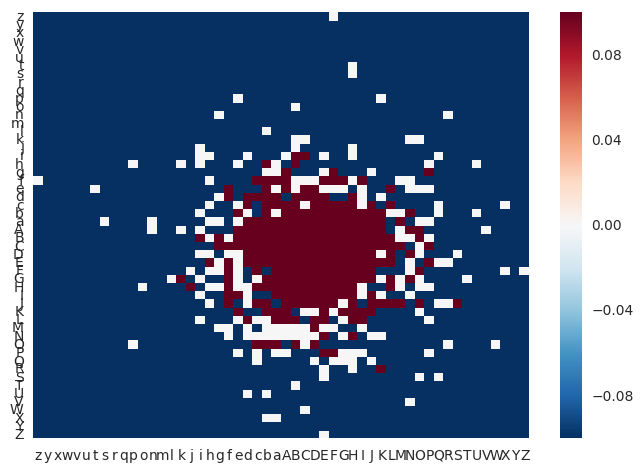

In [14]:
sns.heatmap(mtx.apply(np.log10));

Розрахуємо ймовірності для граматики:

In [15]:
def calculate_probabilities(matrix):
    m = matrix.copy()
    
    for col in m:
        m[col] = m[col].apply(lambda x: x / m[col].sum())
    
    return m.fillna(0)

probability_mtx = calculate_probabilities(mtx)

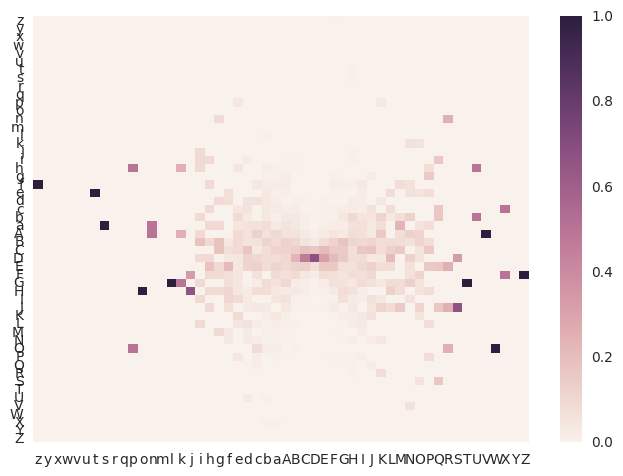

In [16]:
sns.heatmap(probability_mtx);

### Повторюємо процедуру для різницевого ряду $X^{6}$

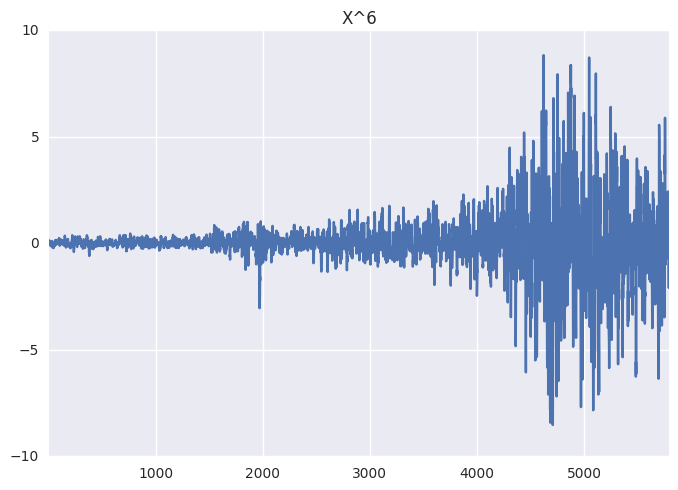

In [17]:
x_diff_6 = x.diff(periods=6).dropna()
x_diff_6.plot(title='X^6');

In [18]:
x_diff_s_6 = x_diff_6.sort_values()

range_bounds_6 = approx_ranges(x_diff_s_6, N)
y_6 = x_diff_6.apply(lambda x: num_to_char(x, range_bounds_6, alphabet))
linguistic_seq_6 = ''.join(y_6.tolist())

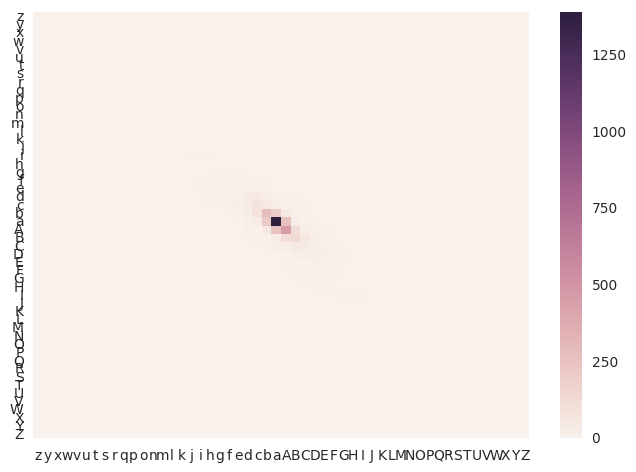

In [19]:
mtx_6 = matrix_of_occurences(linguistic_seq_6, alphabet)
sns.heatmap(mtx_6);

/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:953: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:954: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


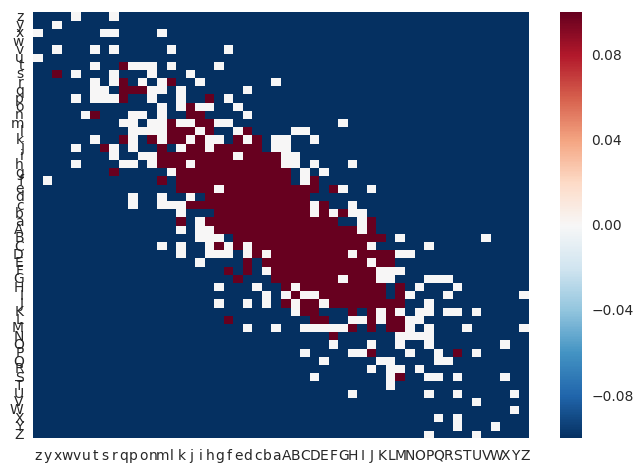

In [20]:
sns.heatmap(mtx_6.apply(np.log10));

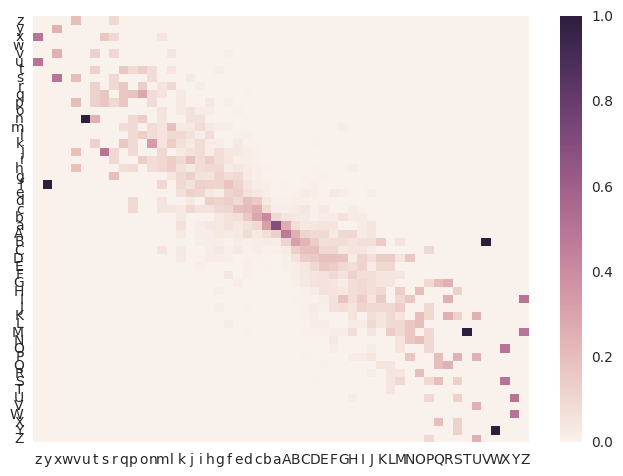

In [21]:
probability_mtx_6 = calculate_probabilities(mtx_6)
sns.heatmap(probability_mtx_6);

### Повторимо для різницевого ряду $X^{1}$ та алфавіту потужністю $10$

In [22]:
alphabet_10 = ['$', '#', '!', '<', '>', '@', '*', '&', '%', '^']
N10 = len(alphabet_10)

range_bounds_a10 = approx_ranges(x_diff_s, N10)
y_a10 = x_diff.apply(lambda x: num_to_char(x, range_bounds_a10, alphabet_10))
linguistic_seq_a10 = ''.join(y_a10.tolist())

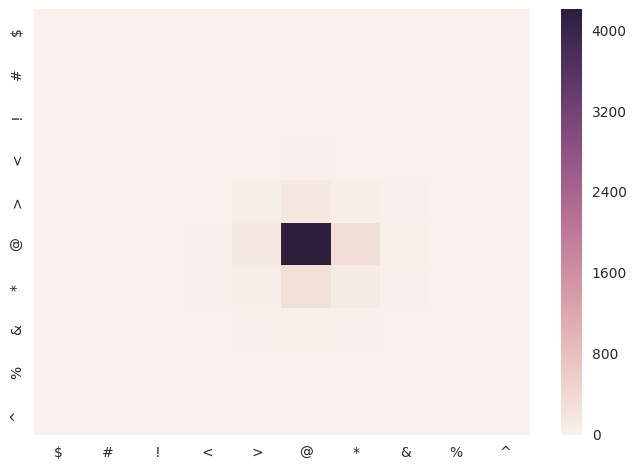

In [23]:
mtx_a10 = matrix_of_occurences(linguistic_seq_a10, alphabet_10)
sns.heatmap(mtx_a10);

/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:953: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:954: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


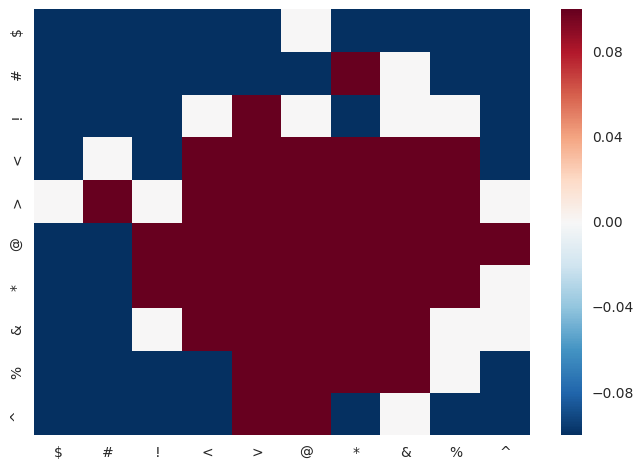

In [24]:
sns.heatmap(mtx_a10.apply(np.log10));

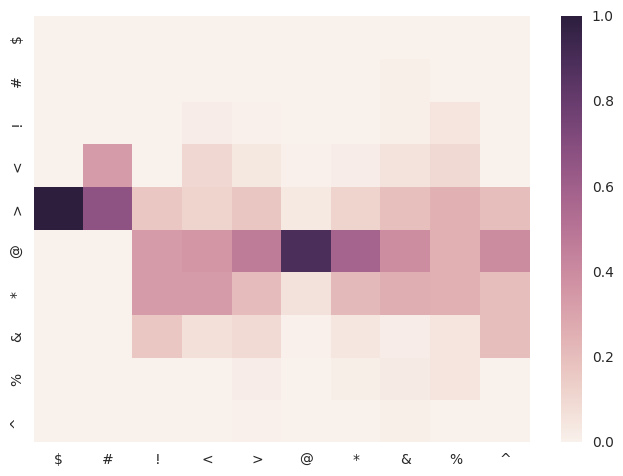

In [25]:
probability_mtx_a10 = calculate_probabilities(mtx_a10)
sns.heatmap(probability_mtx_a10);